# Update to hail proxy of Raupach et al 2023

In [1]:
%cd ~/git/future_hail_global/

/home/561/tr2908/git/future_hail_global


In [2]:
import sys
sys.path.append('../aus400_hail/')
sys.path.append('../xarray_parcel/')
sys.path.append('../warming_levels/')
sys.path.append('../era5_hail_climatology/')

import dask
import json
import xarray
import warnings
import numpy as np
import pandas as pd
import modules.fut_hail as fh
import matplotlib.pyplot as plt
import modules.era5_climatol as ec
import modules.hail_sounding_functions as hs
import modules.updated_proxy as updated_proxy
import modules.parcel_functions as parcel
from dask.distributed import Client

# Allow large chunks.
_ = dask.config.set(**{'array.slicing.split_large_chunks': False})

## Settings

In [3]:
plt.rcParams['figure.figsize'] = (13,5)                                   # Fig. size for non-facet plots.
plt.rcParams['font.size'] = 12                                            # Font size for plots.
plt.rcParams['axes.formatter.useoffset'] = False                          # Don't use offsets in plots.
results_dir = 'results/'                                                  # Results directory.
era5_hail_cache = '~/git/aus400_hail/data/era5_hail_profiles.nc'          # ERA5 cache file for hail.
era5_storm_cache = '~/git/aus400_hail/data/era5_storm_profiles.nc'        # ERA5 cache file for other storms.
era5_nostorm_cache = '~/git/aus400_hail/data/era5_non_storm_profiles.nc'  # ERA5 cache file for no-storm cases.
lookup_dir = '/g/data/w42/tr2908/aus400_hail/'                            # Moist-adiabat lookup cache directory. 
proxy_results_file = '../aus400_hail/results/results_era5.json'           # Trained proxy definition file. 
proxy_conds_file = '~/git/aus400_hail/results/era5_proxy_extra_conds.csv' # Extra proxy conditions file.
base_dir = '/g/data/w42/tr2908/era5_hail_climatology/'                    # Base directory for proxy data.
landsea_file = f'{base_dir}/landsea_mask/landsea_mask_Australia.nc'       # Land-sea file to use.
climatol_dir = f'{base_dir}/era5/'                                        # Hail conditions climatology directory.
proxy_dir = f'{base_dir}/era5_proxy/'                                     # Hail proxy climatology directory.
proxy_nc_dir = f'{base_dir}/era5_proxy/'                                  # Hail proxy with no extra conditions climatology directory.

## Setup

In [4]:
plt.show()                                                 # Start the plotting engine.
plt.rcParams['font.size'] = 16                             # Font size for plots.
plt.rcParams['axes.formatter.useoffset'] = False           # Don't use offsets in plots.
warnings.filterwarnings("ignore", category=FutureWarning)  # Ignore FutureWarnings (in Dask).
results = {}                                               # Empty results dictionary.

In [5]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 7
Total threads: 28,Total memory: 125.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34357,Workers: 7
Dashboard: http://127.0.0.1:8787/status,Total threads: 28
Started: Just now,Total memory: 125.18 GiB
Comm: tcp://127.0.0.1:44269,Total threads: 4
Dashboard: http://127.0.0.1:46851/status,Memory: 17.88 GiB
Nanny: tcp://127.0.0.1:43327,


In [6]:
parcel.load_moist_adiabat_lookups(base_dir=lookup_dir, chunks=-1)

## Load data

Open the original proxy values.

In [ ]:
with open(proxy_results_file, 'r') as f:
    era5_results = json.load(f)
extra_conditions = pd.read_csv(proxy_conds_file)
band_var = era5_results['band_variable']

In [ ]:
updated_proxy.plot_proxy_discrims(era5_results=era5_results, file='results/supplementary/proxy_by_MLH.pdf', figsize=(12,4))

When the melting level height is below about 2000 m, the discriminator line in log-log space is close to vertical meaning that only CAPE matters and shear is not required. Below about 1500 m the slope of the line is negated. We make a simple change so that below 2000 m, the proxy is fixed at the discriminator for 2000 m.

Load era5 data using cached version from proxy training.

In [ ]:
hail_profiles = hs.read_era5_profiles(coords=None, cache_file=era5_hail_cache)
storm_profiles = hs.read_era5_profiles(coords=None, cache_file=era5_storm_cache)
nostorm_profiles = hs.read_era5_profiles(coords=None, cache_file=era5_nostorm_cache)

Calculate convective indices. Note that the version of the environment (eg. analysis3-22.01 vs analysis3-24.04 etc) has small effects on the values produced for convective parameters.

In [ ]:
%%capture 
# Using %%capture to discard long output.
conv_hail = hs.profile_properties(profiles=hail_profiles).to_dataframe()
conv_storm = hs.profile_properties(profiles=storm_profiles).to_dataframe()
conv_nostorm = hs.profile_properties(profiles=nostorm_profiles).to_dataframe()

# Remove duplicated storms.
conv_hail = conv_hail[~conv_hail.duplicated()]
conv_storm = conv_storm[~conv_storm.duplicated()]
conv_nostorm = conv_nostorm[~conv_nostorm.duplicated()]

# Set hail flags.
conv_hail['true_hail'] = True
conv_storm['true_hail'] = False
conv_nostorm['true_hail'] = False
d = pd.concat([conv_hail, conv_storm, conv_nostorm])

Apply both the original proxy (`old_proxy`) and the one with limits on the MLH values accepted (`new proxy`).

In [ ]:
d['old_proxy'] = updated_proxy.apply_proxy(dat=d, band_var=band_var, 
                                           alpha_a=era5_results['hail_alpha_a'],
                                           alpha_b=era5_results['hail_alpha_b'], 
                                           beta_a=era5_results['hail_beta_a'], 
                                           beta_b=era5_results['hail_beta_b'],
                                           band_limits=None)

In [ ]:
d['new_proxy'] = updated_proxy.apply_proxy(dat=d, band_var=band_var, 
                                           alpha_a=era5_results['hail_alpha_a'],
                                           alpha_b=era5_results['hail_alpha_b'], 
                                           beta_a=era5_results['hail_beta_a'], 
                                           beta_b=era5_results['hail_beta_b'],
                                           band_limits=[2000, None])

The original "extra condition" thresholds from Raupach et al., 2023 were:

```
Threshold of lapse_rate_700_500 < -5.45 will remove ~2.5% of good (Hail) points but ~13.0% of bad points.
Threshold of mixed_100_lifted_index < 0.4 will remove ~2.5% of good (Hail) points but ~10.0% of bad points.
Threshold of temp_500 < 265.46 will remove ~2.5% of good (Hail) points but ~9.0% of bad points.
```

The next bit of code shows proxy performance metrics before and after the extra conditions are added, plus the effect of extra conditions, for the original proxy and then the updated proxy on the same training data used in Raupach et al., 2023 (MWR).

In [ ]:
updated_proxy.prox_performance(dat=d.copy(), proxy='old_proxy', extra_conditions=extra_conditions)

In [ ]:
updated_proxy.prox_performance(dat=d.copy(), proxy='new_proxy', extra_conditions=extra_conditions)

## Effect of change on climatology/trend

Now we turn to the proxy climatology used in Raupach et al., 2023 (npj). Read in all the data and apply both the old and new proxies to them.

In [7]:
%%time
climatol_all, climatol_land, nonphys_perc = updated_proxy.era5_proxies(climatol_dir=climatol_dir, landsea_file=landsea_file, 
                                                                       results_file=proxy_results_file, extra_conds_file=proxy_conds_file)

CPU times: user 2min 26s, sys: 16.3 s, total: 2min 42s
Wall time: 3min 56s


In [8]:
monthly = climatol_land.groupby('time.month').mean(keep_attrs=True).load()


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 17.83 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


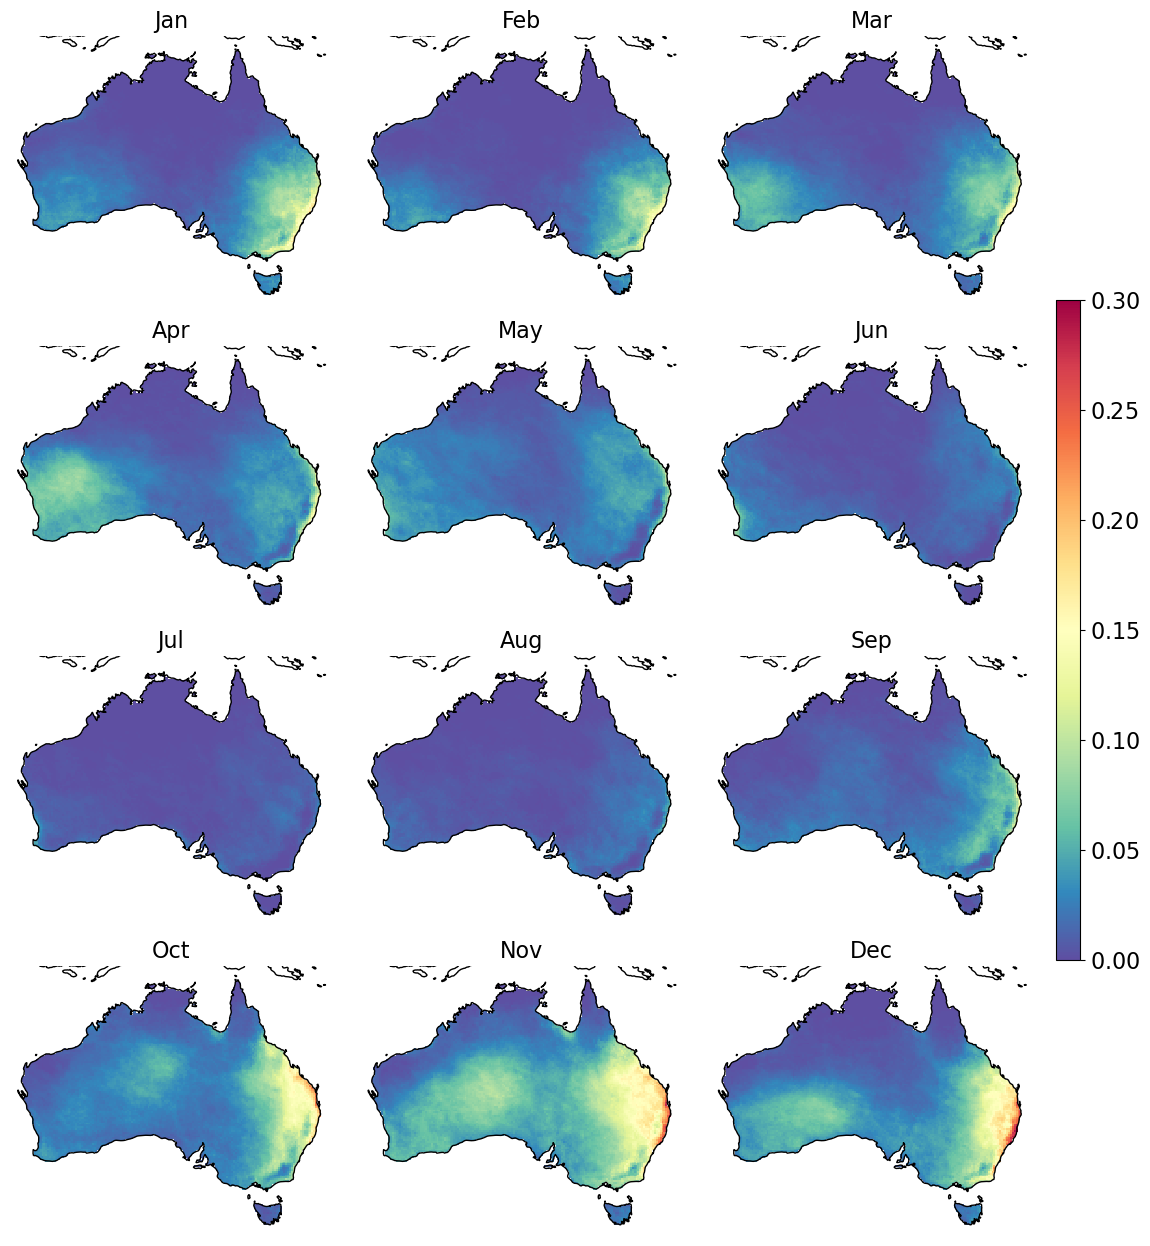

In [9]:
months = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec',
}

_ = fh.plot_map(
    [monthly.new_prox.sel(month=m) for m in np.arange(1, 13)],
    title=[months[m] for m in np.arange(1, 13)],
    ncols=3,
    nrows=4,
    figsize=(12,12),
    share_scale=True,
    share_axes=True,
    hspace=0.15,
    grid=False,
    nan_colour='white',
    cmap='Spectral_r',
    axis_off=True,
)

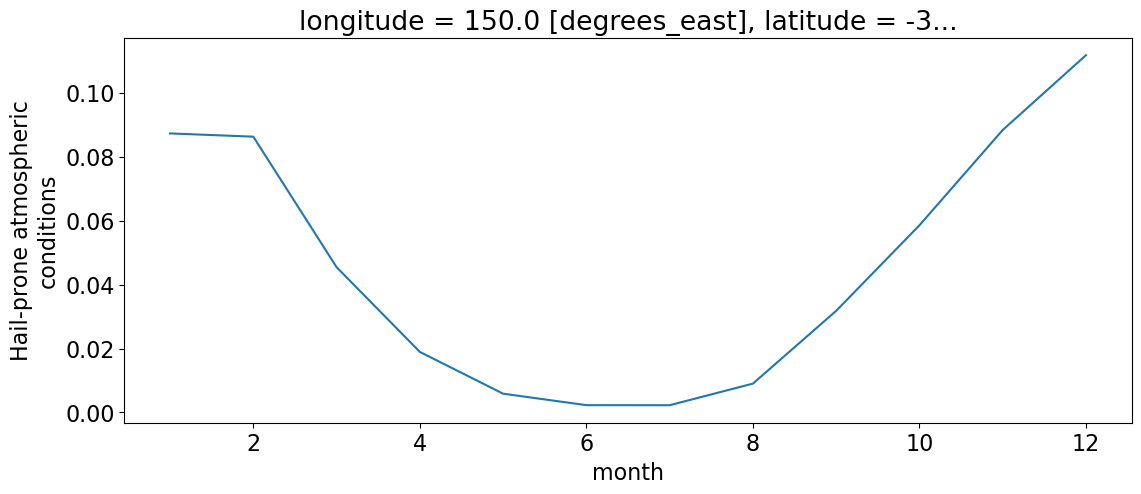

In [18]:
monthly.new_prox.sel(latitude=-34, longitude=150, method='nearest').plot()

Uncomment the following cell to check that the old proxy calculation used here matches that used in Raupach et al., 2023b (npj) (it does match but the code is slow so not run every time).

In [ ]:
# climatol_all_orig, climatol_land_orig, _ = ec.read_era5(climatol_dir=climatol_dir, proxy_dir=proxy_dir, 
#                                                         proxy_nc_dir=None, landsea_file=landsea_file)
# assert climatol_all.old_prox.equals(climatol_all_orig.hail_proxy), 'Old proxies do not match.'

Calculate points where the old and updated proxies do not agree and find the percentage of time disagreement occurred, per pixel.

In [ ]:
prox_diff = climatol_all.new_prox != climatol_all.old_prox
percent_diff_per_pixel = (prox_diff.sum('time') / len(prox_diff.time) * 100).load()

Print out the maximum percentage changes across the whole domain and across land points only.

In [ ]:
lsm = xarray.open_dataset(landsea_file)
results['max_percent_diff_per_pixel_all'] = np.round(percent_diff_per_pixel.max().values, 3)
results['max_percent_diff_per_pixel_land'] = np.round(percent_diff_per_pixel.where(lsm.lsm > 0.5).max().values, 3)

print(f'Over the whole ERA5 dataset used previously:')
print(f'At most, a pixel has {results["max_percent_diff_per_pixel_all"]}% of its values changed by the proxy change.')
print(f'At most over land, a pixel has {results["max_percent_diff_per_pixel_land"]}% of its values changed by the proxy change.')

In [ ]:
percent_diff_per_pixel.attrs['long_name'] = '% of time proxies disagree'
_ = fh.plot_map(percent_diff_per_pixel, figsize=(8,8))

Calculate proxy climatologies using the original and updated proxies for comparison.

In [ ]:
def climatol(climatol_all, v):
    d = climatol_all.sel(time=slice('1979', '2021'))
    
    def per_year(x, v):
        mask = np.logical_not(np.isnan(x[v].max('time')))
        return x[v].resample(time='1Y').sum('time').mean('time').where(mask)
            
    d = per_year(d, v)
    return d

climatol_old = climatol(climatol_all, v='old_prox').load()
climatol_new = climatol(climatol_all, v='new_prox').load()

Calculate differences and relative differences in the climatologies and plot them.

In [ ]:
climatol_diffs = (climatol_new - climatol_old)
climatol_reldiffs = climatol_diffs / climatol_old * 100

climatol_diffs.attrs['long_name'] = '\Delta mean annual hail-prone days'
climatol_reldiffs.attrs['long_name'] = 'Relative difference in mean annual hail-prone days [%]'

_ = fh.plot_map([climatol_diffs, climatol_reldiffs], ncols=2,
                cmap='RdBu_r', divergent=True, figsize=(10,4), wspace=0.3)

Calculate the trends using old and updated proxies, for comparison.

In [ ]:
%%time
climatol_land['old_prox'] = climatol_land.old_prox.chunk({'latitude': 20, 'longitude': 20, 'time': -1})
climatol_land['new_prox'] = climatol_land.new_prox.chunk({'latitude': 20, 'longitude': 20, 'time': -1})

yearly, seasonal = ec.calc_all_trends(dat=climatol_land, norm_variables=['old_prox', 'new_prox'], 
                                      norm_units={'new_prox': 'days',
                                                  'old_prox': 'days'},
                                      q_variables={}, do_seasonal=False, no_cache=True)

A comparison of the trends shows very similar results between the two proxies.

In [ ]:
_ = fh.plot_map([yearly['old_prox'].slope, yearly['new_prox'].slope], figsize=(10,4),
                title=['Original proxy', 'Updated proxy'], scale_label='Trend in hail-prone\ndays per decade',
                ncols=2, cmap='RdBu_r', divergent=True, share_scale=True, share_axes=True)

Plot differences and relative differences to show that there are no great changes.

In [ ]:
diffs = yearly['new_prox'].slope - yearly['old_prox'].slope
reldiffs = diffs / yearly['old_prox'].slope

diffs.attrs['long_name'] = 'Slope difference\n[days per decade]'
reldiffs.attrs['long_name'] = 'Relative slope difference [%]'

_ = fh.plot_map([diffs, reldiffs], ncols=2, cmap='RdBu_r',
                divergent=True, figsize=(10,4), wspace=0.45)

In [ ]:
results_file = open('results/results_proxy_update.json', 'w')
json.dump(results, results_file)
results_file.close()